In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
%matplotlib inline

# 定义参数

In [2]:
K = 20

# 函数

In [3]:
def rank_percentile(array):
    """
    返回s的最后一个元素在s中的分位值
    """
    s = pd.Series(array)
    s = s.rank(pct=True)
    return s.iloc[-1]

In [4]:
def roll(df, w):
    """
    This fucntion comes from:
    http://stackoverflow.com/questions/37486502/why-does-pandas-rolling-use-single-dimension-ndarray/37491779#37491779
    """
    df.fillna(df.mean(), inplace=True)
    roll_array = np.dstack([df.values[i:i+w, :] for i in range(len(df.index) - w + 1)]).T
    panel = pd.Panel(roll_array,
                     items=df.index[w-1:],
                     major_axis=df.columns,
                     minor_axis=pd.Index(range(w), name='roll'))
    return panel.to_frame().unstack().T.groupby(level=0)

# 读取产出数据

In [5]:
macro_df = pd.read_excel('./data/scenario.xlsx', sheetname='macro', index_col=0)

In [6]:
macro_df.shape

(128, 1)

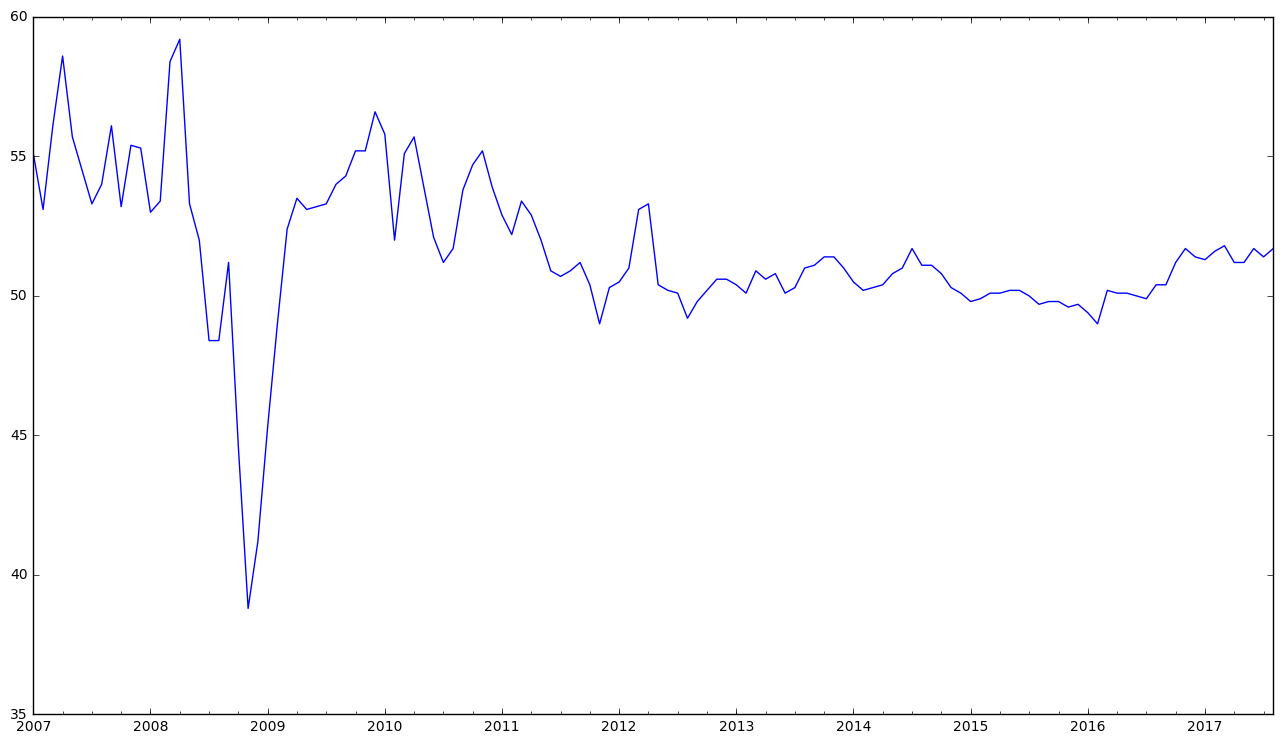

In [7]:
plt.figure(figsize=(16, 9))
macro_df['PMI'].plot()

In [8]:
inf_df = pd.read_excel('./data/scenario.xlsx', sheetname='inflation', index_col=0)

In [9]:
inf_df.shape

(128, 2)

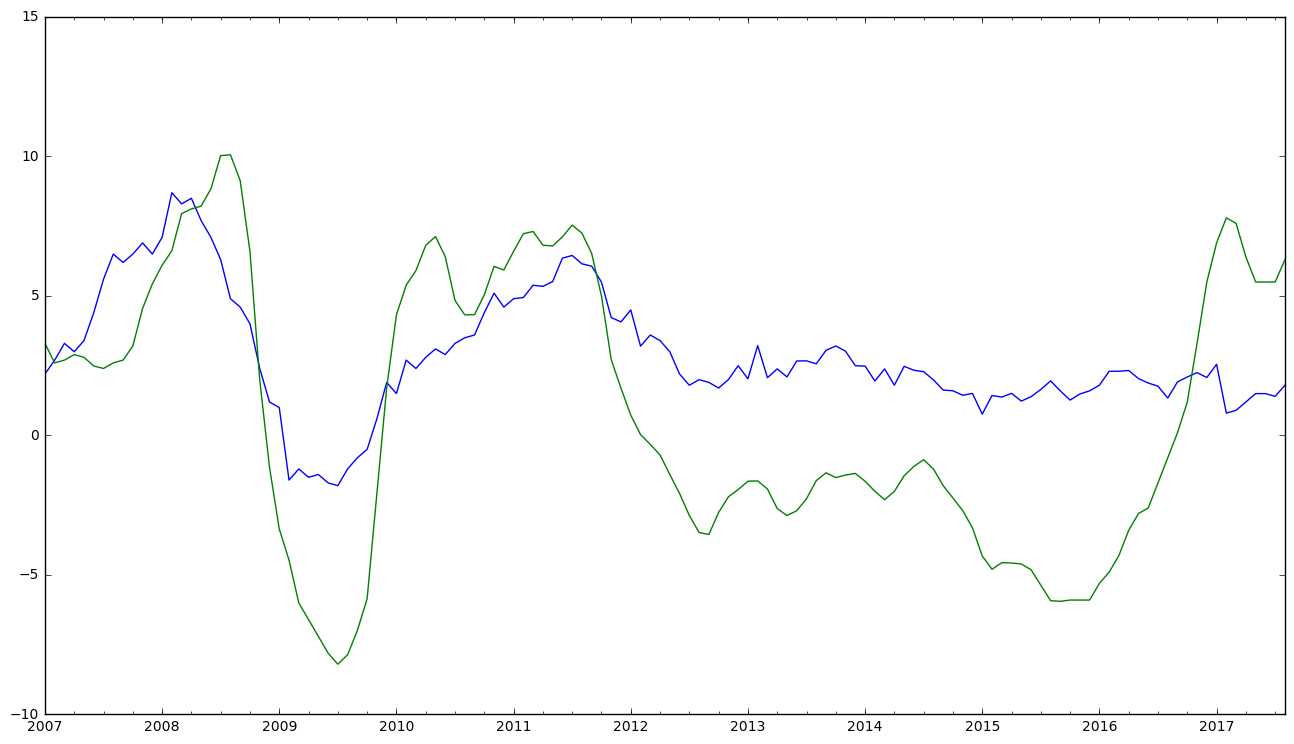

In [10]:
plt.figure(figsize=(16, 9))
inf_df['CPI'].plot()
inf_df['PPI'].plot()

In [11]:
df = macro_df.merge(inf_df, left_index=True, right_index=True)

In [12]:
roll_df = df.copy()

In [13]:
for col in roll_df.columns:
     roll_df.loc[:, col] = roll_df[col].rolling(window=24).apply(lambda x: rank_percentile(x))

In [14]:
roll_df = roll_df.dropna()

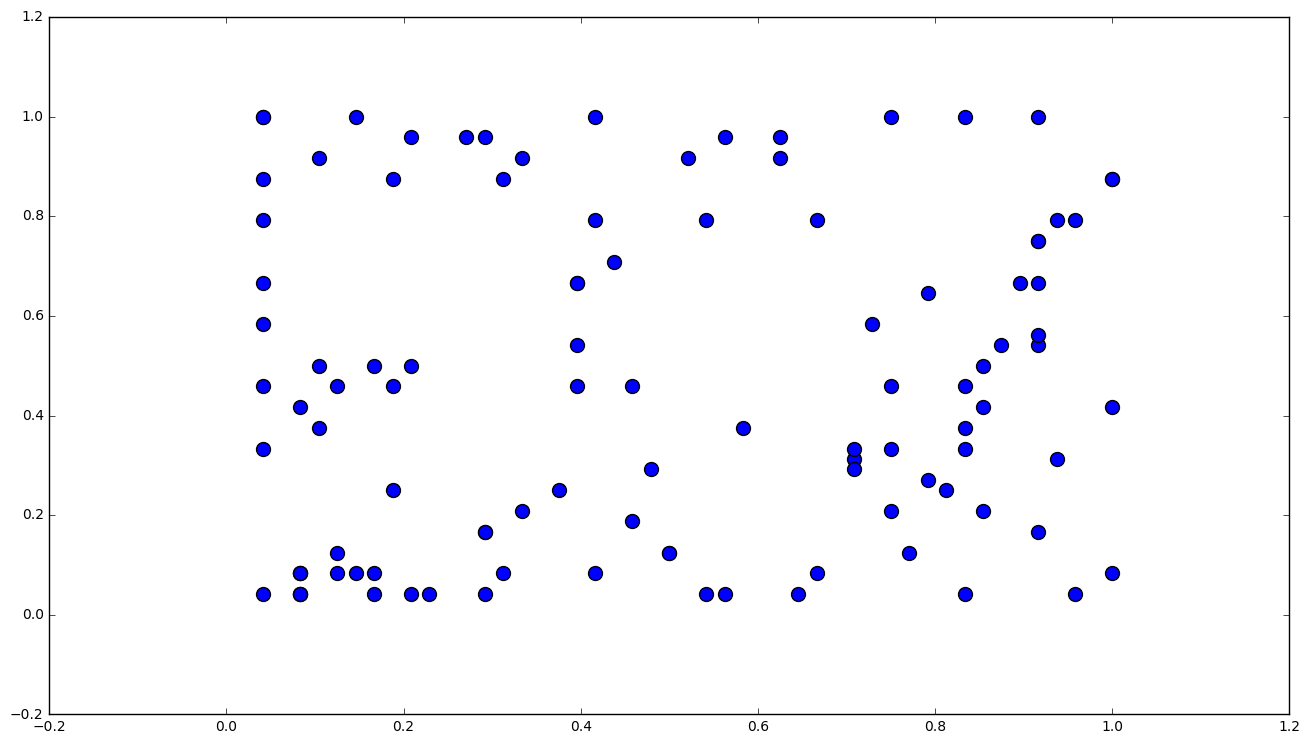

In [15]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], s=100)
# sns.lmplot('PMI', 'CPI', data=roll_df, fit_reg=False)

In [16]:
kmeans = KMeans(n_clusters=4)

In [17]:
kmeans.fit(roll_df[['PMI', 'CPI']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [18]:
roll_df.loc[:, 'label'] = kmeans.labels_

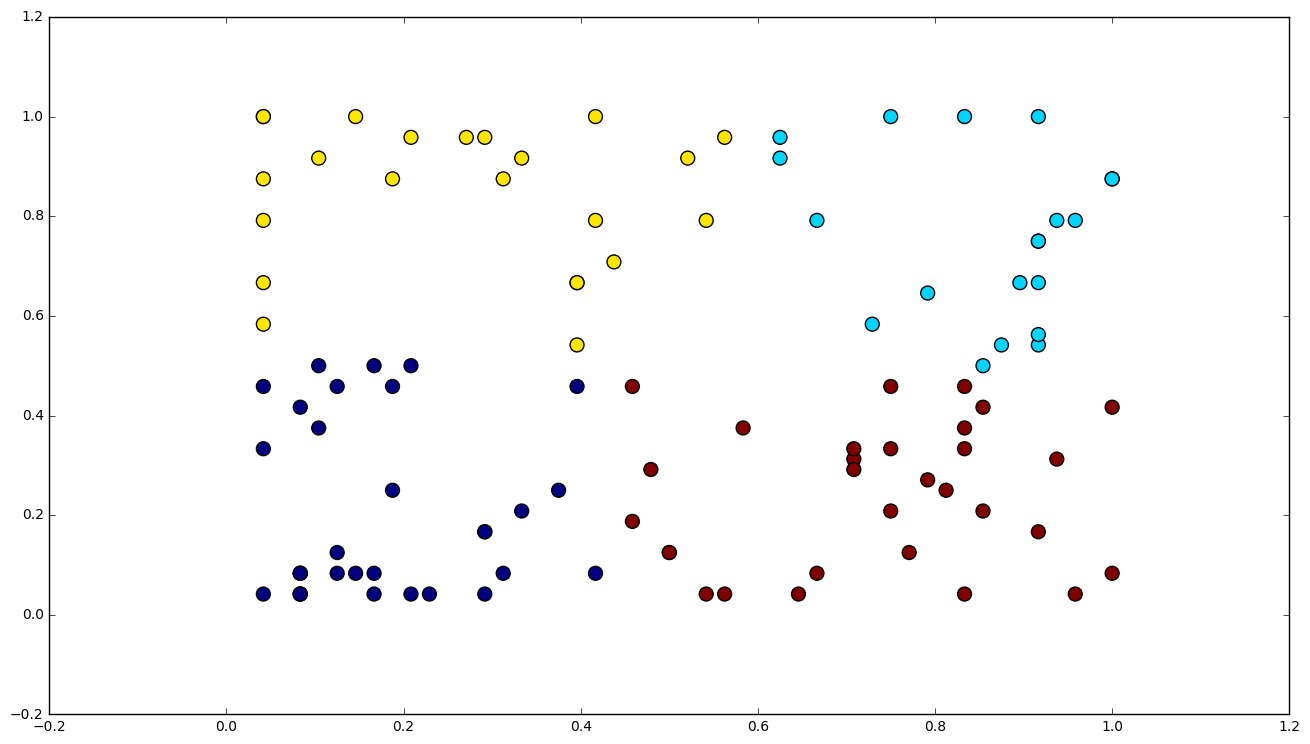

In [19]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], c=roll_df['label'], s=100)

In [20]:
kmeans.cluster_centers_

array([[ 0.17708333,  0.20703125],
       [ 0.85208333,  0.76041667],
       [ 0.26902174,  0.8442029 ],
       [ 0.73333333,  0.24027778]])

In [21]:
roll_df.to_excel('C:/Users/jgtzsx01/Desktop/plot.xlsx')

# 美国数据验证

In [22]:
df = pd.read_excel('./data/us.xlsx', index_col=0)

In [23]:
df.head()

,PMI,CPI
1990-01-31,47.2,5.2
1990-02-28,49.1,5.3
1990-03-31,49.9,5.2
1990-04-30,50.0,4.7
1990-05-31,49.5,4.4


In [24]:
roll_df = df.copy()

In [25]:
for col in roll_df.columns:
     roll_df.loc[:, col] = roll_df[col].rolling(window=36).apply(lambda x: rank_percentile(x))

In [26]:
roll_df['time'] = range(roll_df.shape[0])
roll_df['time'] /= roll_df.shape[0]

In [27]:
roll_df = roll_df.dropna()

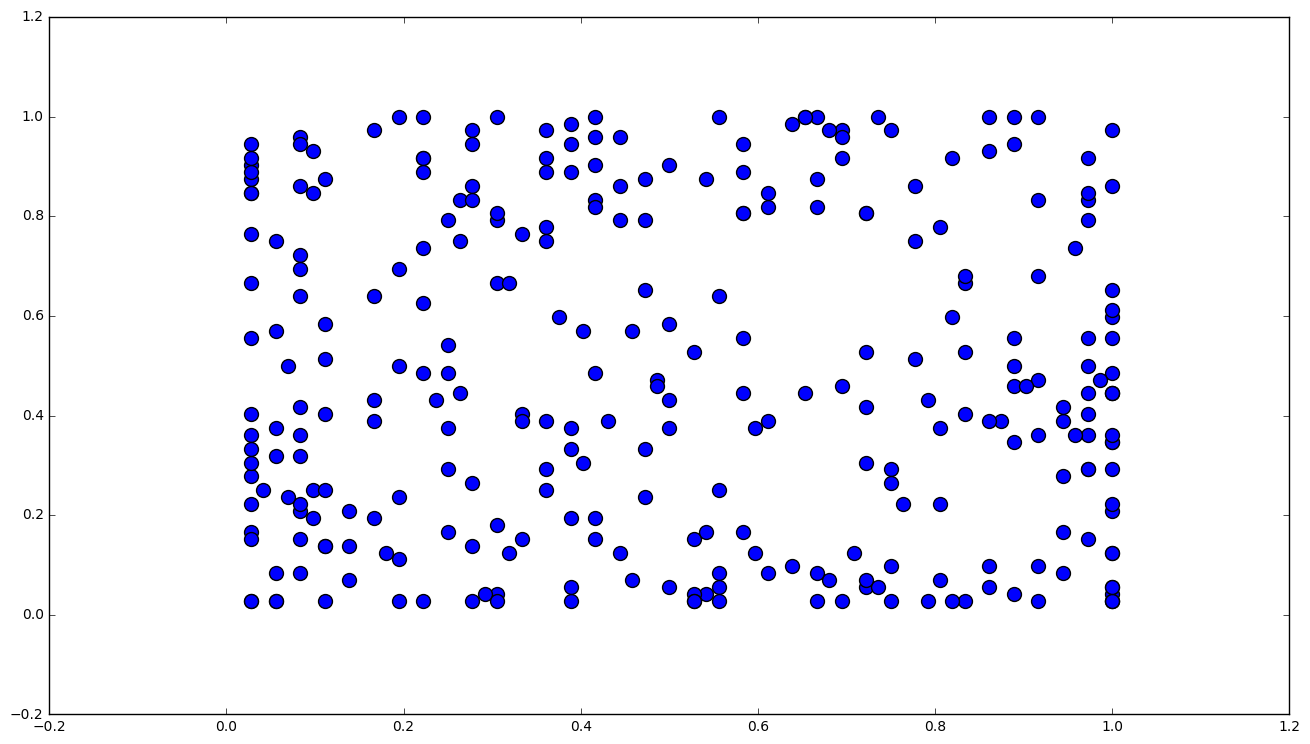

In [28]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], s=100)
# sns.lmplot('PMI', 'CPI', data=roll_df, fit_reg=False)

In [29]:
kmeans = KMeans(n_clusters=4)

In [30]:
kmeans.fit(roll_df[['PMI', 'CPI']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
roll_df.loc[:, 'label'] = kmeans.labels_

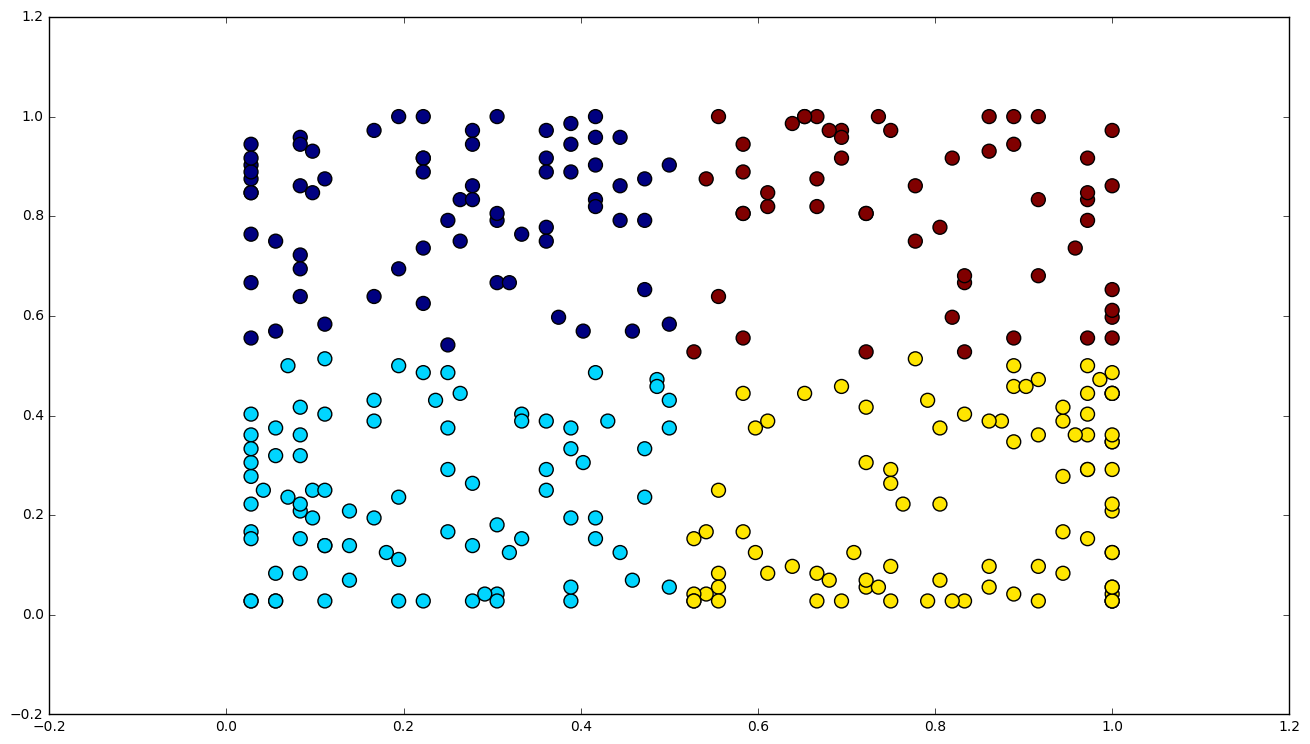

In [32]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], c=roll_df['label'], s=100)

In [33]:
kmeans.cluster_centers_

array([[ 0.24880952,  0.8140873 ],
       [ 0.22107843,  0.24362745],
       [ 0.81944444,  0.2282197 ],
       [ 0.78034979,  0.81430041]])

In [34]:
roll_df.to_excel('C:/Users/jgtzsx01/Desktop/plot.xlsx')

# 读取股市价格数据

In [35]:
stock_price_df = pd.read_excel('./data/scenario.xlsx', sheetname='stock price', index_col=0)

In [36]:
stock_price_df.head()

,881001.WI,CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2007-01-04,1461.2643,1892.8201,974.2955,2157.3977,1104.6818,1528.2028,1361.8658,1193.3808,1603.8291,1076.6587,...,1505.7654,3067.4000,3858.3818,2219.0890,1254.3270,1198.3596,1377.1940,789.2537,1588.5191,1047.8365
2007-01-05,1474.4288,1883.2709,1040.7031,2205.4000,1163.9973,1535.8329,1408.4904,1237.0404,1610.7655,1103.3408,...,1533.4037,2874.9153,3807.9942,2194.5230,1295.6236,1248.8008,1364.1011,806.6564,1612.7583,1078.1789
2007-01-08,1522.0564,1928.4159,1060.9361,2294.0467,1208.9866,1553.1086,1453.9615,1278.7277,1698.0464,1151.7333,...,1600.1341,2940.1016,3867.7266,2266.2155,1335.1320,1319.1332,1406.6479,852.6989,1659.7813,1122.7703
2007-01-09,1564.7432,2049.7174,1075.7320,2363.3052,1225.2765,1662.0667,1495.0332,1298.5757,1710.6075,1165.8915,...,1632.4168,3062.6504,4069.6942,2318.6704,1357.5389,1335.5204,1434.0367,860.5352,1690.2576,1141.0377
2007-01-10,1603.9025,2047.5022,1105.2637,2481.5205,1256.6071,1688.5565,1531.6617,1325.4738,1758.3335,1197.3918,...,1662.1529,3095.7356,4340.8602,2433.1239,1412.3879,1386.0050,1448.7325,887.4971,1696.8470,1180.8804


In [37]:
roll_df = stock_price_df.copy()

In [38]:
del roll_df['881001.WI']

In [39]:
for col in roll_df.columns:
     roll_df.loc[:, col] = roll_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

In [40]:
roll_df = roll_df.dropna()

### PCA分解

In [41]:
pca = PCA(n_components=5)

In [42]:
pca.fit(roll_df)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
pca.explained_variance_ratio_

array([ 0.7083193 ,  0.12584419,  0.06730505,  0.02114948,  0.01466734])

In [44]:
X_tran = pca.transform(roll_df)

In [45]:
X_tran_df = pd.DataFrame(X_tran, index=roll_df.index, columns=range(5))

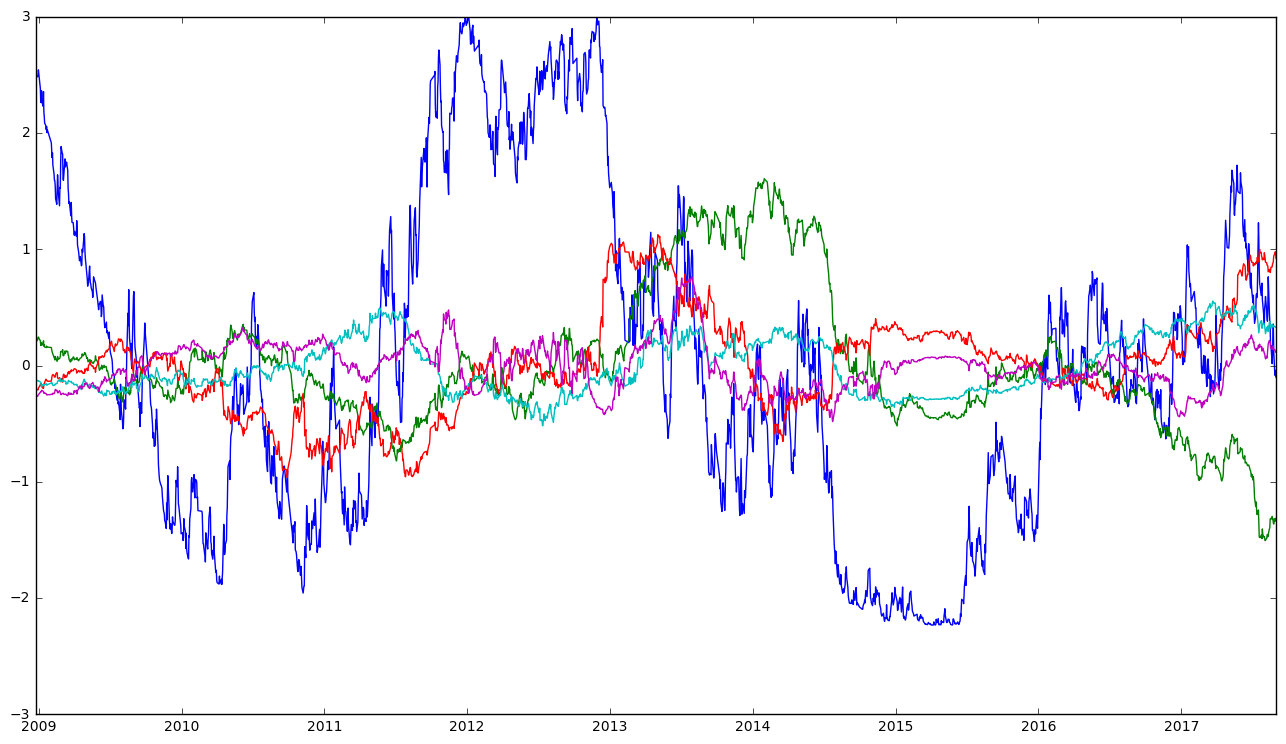

In [46]:
plt.figure(figsize=(16, 9))
plt.plot(X_tran_df[0])
plt.plot(X_tran_df[1])
plt.plot(X_tran_df[2])
plt.plot(X_tran_df[3])
plt.plot(X_tran_df[4])

In [47]:
X_tran_df = X_tran_df.resample('M').last()

In [48]:
series = macro_df['PMI'].rolling(window=24).apply(lambda x: rank_percentile(x))
X_tran_df['PMI'] = series[series.index >= X_tran_df.index[0]]
series = inf_df['CPI'].rolling(window=24).apply(lambda x: rank_percentile(x))
X_tran_df['CPI'] = series[series.index >= X_tran_df.index[0]]

In [49]:
pca = PCA(n_components=2)

In [50]:
X_tran = pca.fit_transform(X_tran_df)

In [51]:
X_tran_df = pd.DataFrame(X_tran, index=X_tran_df.index, columns=range(2))

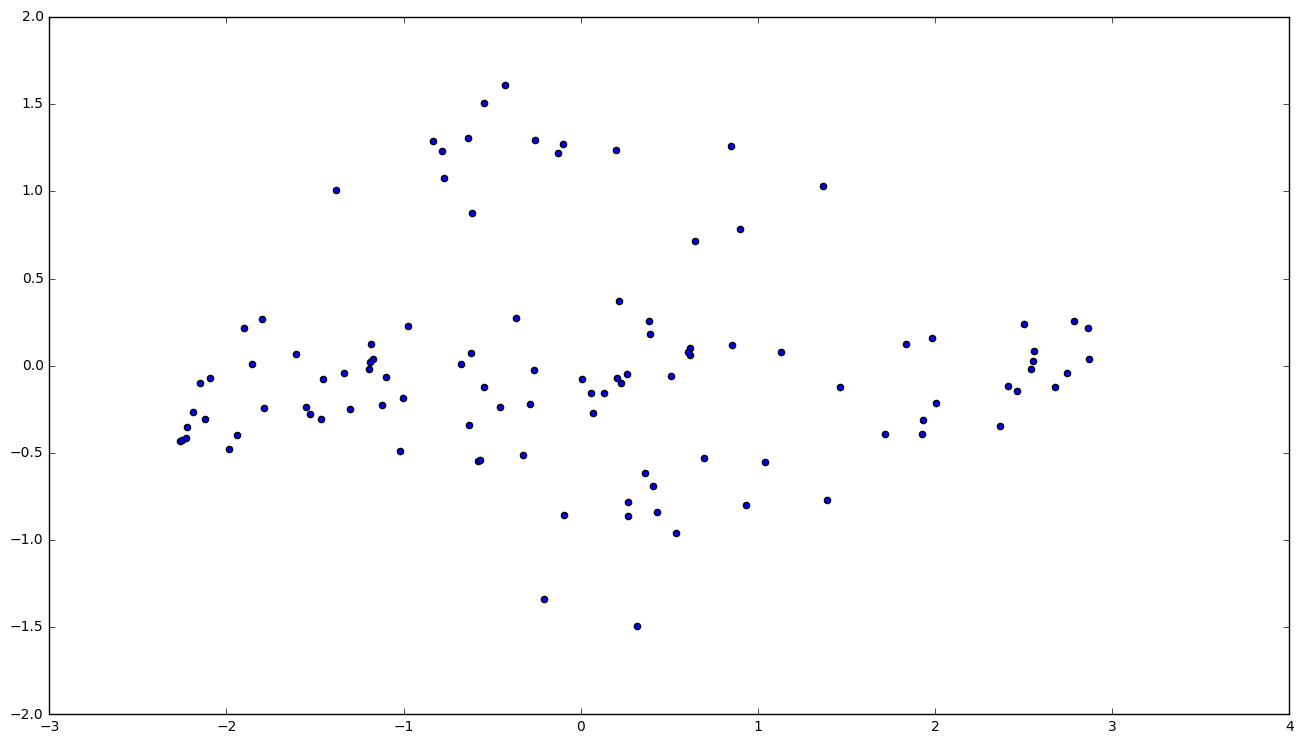

In [52]:
plt.figure(figsize=(16, 9))
plt.scatter(X_tran_df[0], X_tran_df[1])

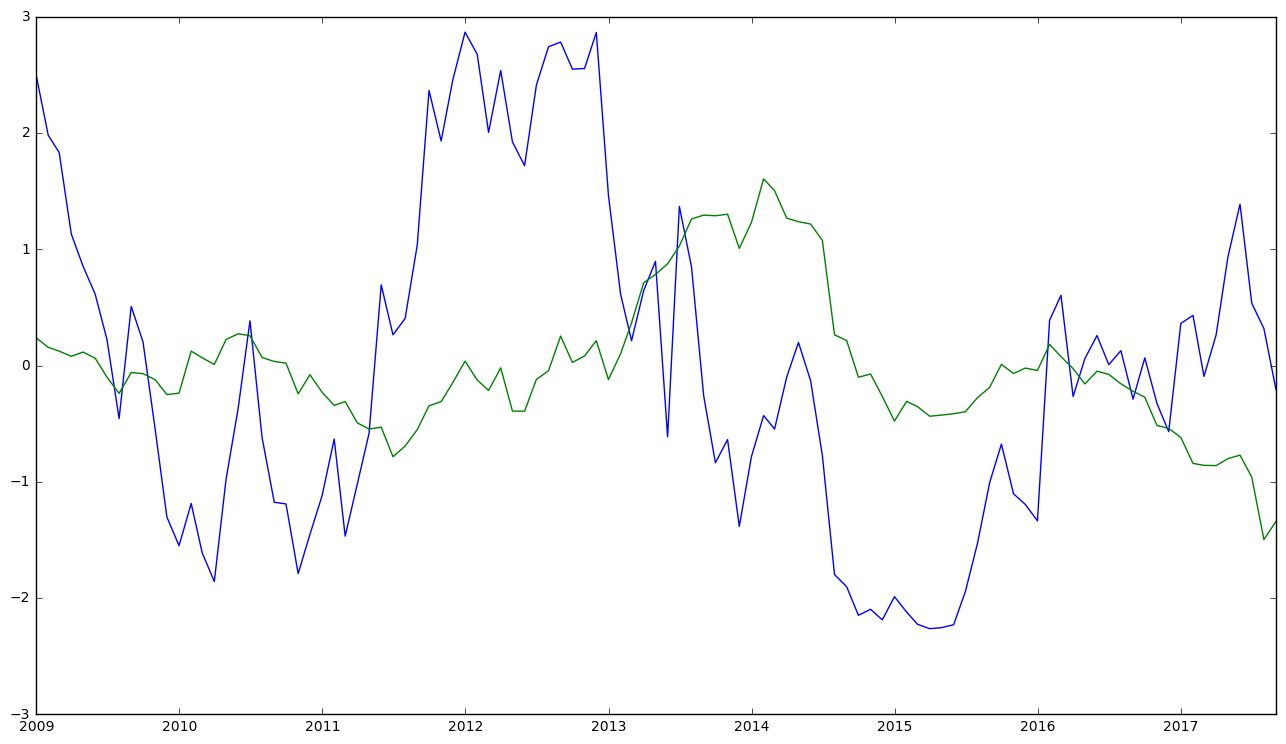

In [53]:
plt.figure(figsize=(16, 9))
plt.plot(X_tran_df[0])
plt.plot(X_tran_df[1])

# 读取债市数据

In [54]:
int_df = pd.read_excel('./data/scenario.xlsx', sheetname='interest rate', index_col=0)

In [55]:
for col in int_df.columns:
    int_df[col] = int_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

# 读取商品数据

In [56]:
com_df = pd.read_excel('./data/scenario.xlsx', sheetname='commodity', index_col=0)

In [57]:
for col in com_df.columns:
    com_df[col] = com_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

# 读取股市成交量数据

In [58]:
vol_df = pd.read_excel('./data/scenario.xlsx', sheetname='stock volume', index_col=0)

In [59]:
for col in vol_df.columns:
    vol_df[col] = vol_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

# 读取汇率数据

In [60]:
cur_df = pd.read_excel('./data/scenario.xlsx', sheetname='currency', index_col=0)

In [61]:
for col in cur_df.columns:
    cur_df[col] = cur_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

# 综合数据

In [62]:
df = cur_df.resample('M').last()

In [63]:
df['st vol'] = vol_df.resample('M').last()

In [64]:
df['commodity'] = com_df.resample('M').last()

In [65]:
df[['CGB1Y', 'CGB10Y']] = int_df.resample('M').last()

In [66]:
df['st price'] = stock_price_df['881001.WI'].rolling(window=484).apply(lambda x: rank_percentile(x)).resample('M').last()

In [67]:
df['CPI'] = inf_df['CPI'].rolling(window=24).apply(lambda x: rank_percentile(x))

In [68]:
df['PMI'] = macro_df['PMI'].rolling(window=24).apply(lambda x: rank_percentile(x))

In [69]:
df = df.dropna()

In [70]:
pca = PCA(n_components=5)

In [71]:
X = pca.fit_transform(df)

In [72]:
pca.explained_variance_ratio_

array([ 0.37312209,  0.20830809,  0.17945902,  0.09014217,  0.0780663 ])

In [73]:
Xdf = pd.DataFrame(X, index=df.index, columns=range(5))

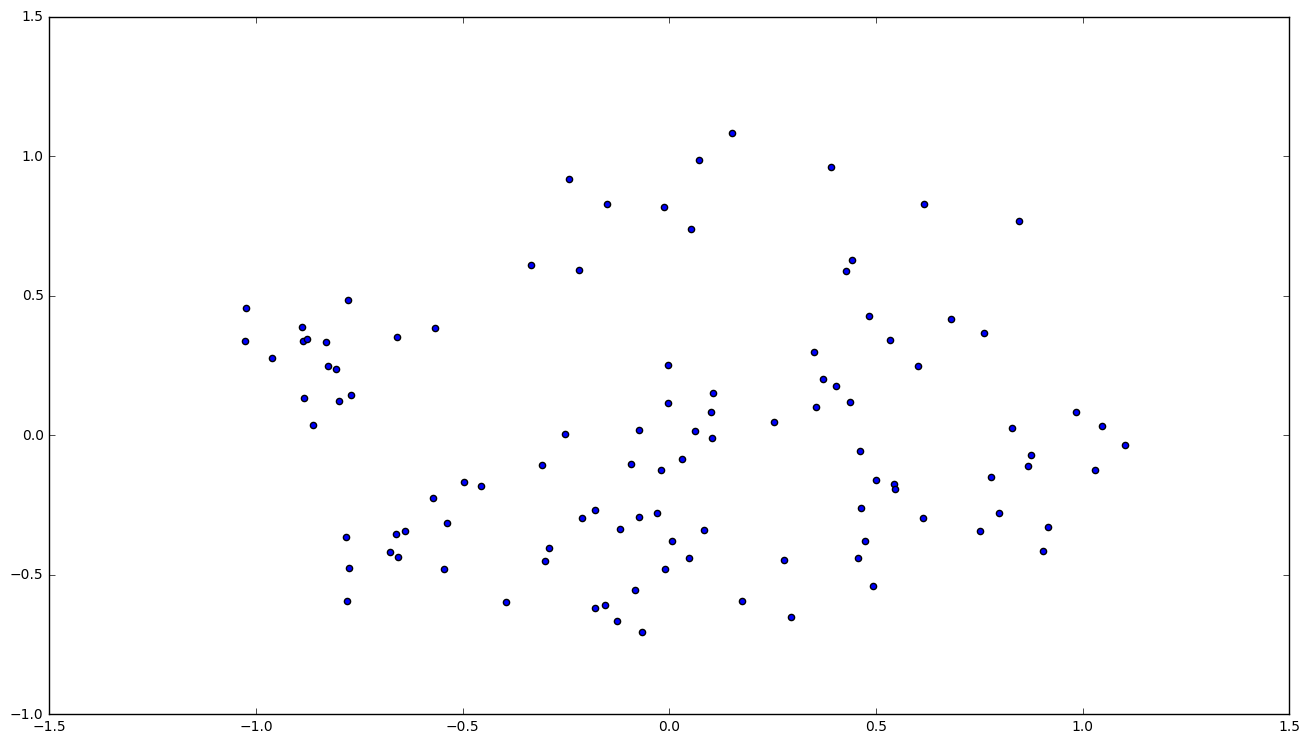

In [74]:
plt.figure(figsize=(16, 9))
plt.scatter(Xdf[0], Xdf[1])

In [88]:
kmeans = KMeans(n_clusters=4)

In [89]:
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [90]:
Xdf['label'] = kmeans.labels_

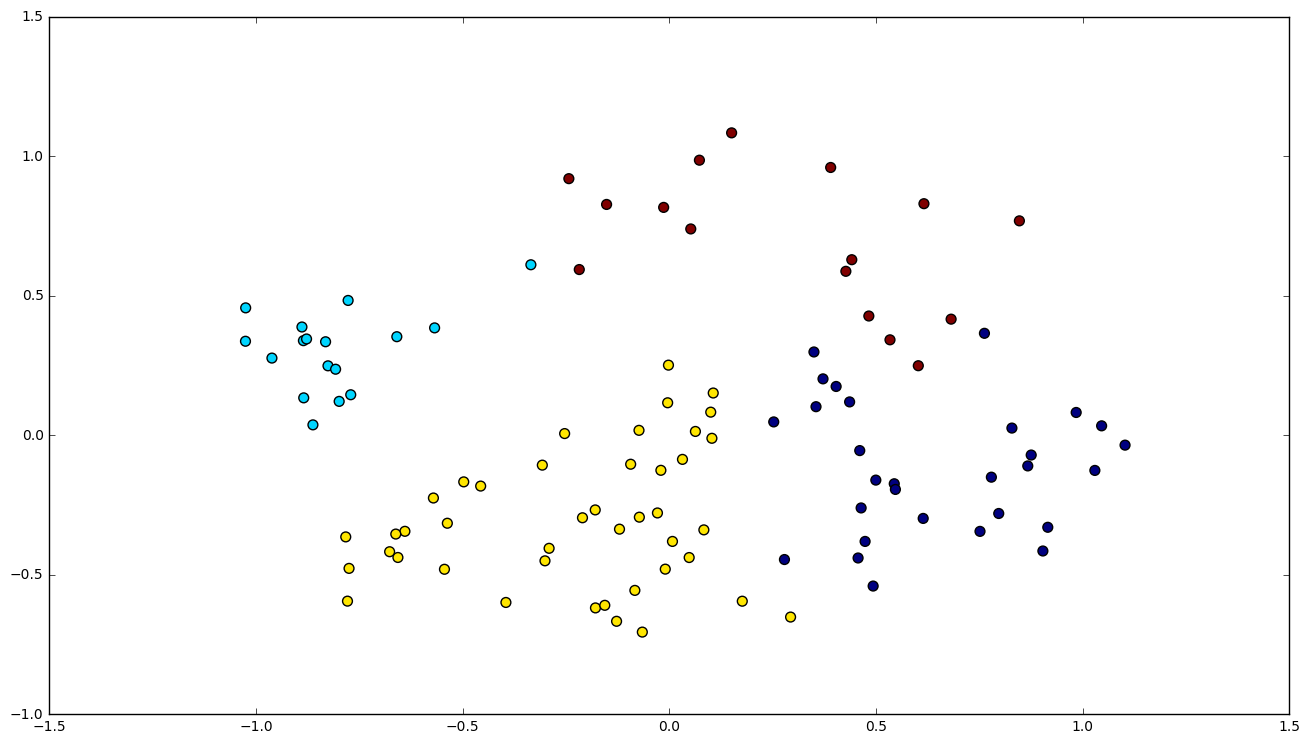

In [91]:
plt.figure(figsize=(16, 9))
plt.scatter(Xdf[0], Xdf[1], c=Xdf['label'], s=50)

In [93]:
Xdf[Xdf['label'] == 1]

,0,1,2,3,4,label
2017-04-30,0.482753,0.428092,-0.013529,0.501184,0.551281,3
2017-05-31,0.602419,0.249905,-0.083060,0.398355,0.509837,3
2017-06-30,0.681795,0.416788,0.056885,0.461718,0.408010,3
2017-07-31,0.533921,0.342745,0.499902,0.224152,0.076124,3
2017-08-31,0.762401,0.366078,0.478480,0.083913,-0.117848,0


In [415]:
df1 = pd.read_excel('./data/scenario.xlsx', sheetname='stock price', index_col=0)

In [416]:
df2 = pd.read_excel('./data/scenario.xlsx', sheetname='interest rate', index_col=0)

In [417]:
df1 = df1.resample('M').last()

In [418]:
df2 = df2.resample('M').last()

In [439]:
odf = df1[['881001.WI']]
odf['yield1y'] = df2['CGB1Y']
odf['yield10y'] = df2['CGB10Y']

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [440]:
odf = odf[odf.index >= Xdf.index[0]]

In [441]:
odf['label'] = Xdf['label']

In [443]:
odf.to_excel('C:/Users/jgtzsx01/Desktop/history.xlsx')

In [449]:
Xdf.to_excel('C:/Users/jgtzsx01/Desktop/plot.xlsx')

In [450]:
ret_df = stock_price_df.pct_change()

In [455]:
pf.empyrical.annual_volatility(ret_df[(ret_df.index >= '2009-09-01') & (ret_df.index <= '2011-09-30')]['881001.WI'])

0.2244274063020149

In [458]:
(1+ret_df[(ret_df.index >= '2009-09-01') & (ret_df.index <= '2011-09-30')]['881001.WI']).cumprod()[-1]

1.0095513081332099

In [464]:
pf.empyrical.annual_volatility(ret_df[(ret_df.index >= '2013-07-01') & (ret_df.index <= '2014-08-01')]['881001.WI'])

0.1888041007924011

In [463]:
(1+ret_df[(ret_df.index >= '2013-07-01') & (ret_df.index <= '2014-08-01')]['881001.WI']).cumprod()[-1]

1.2379190402183415

In [466]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [467]:
kmeans.cluster_centers_

array([[ 0.77968682,  0.76652893,  0.08579817,  0.1914963 ,  0.12951283,
         0.84710744,  0.30263158,  0.21052632],
       [ 0.13192428,  0.4885526 ,  0.5809694 ,  0.81142506,  0.75424391,
         0.65992852,  0.71058559,  0.58896396],
       [ 0.11808164,  0.53243176,  0.23747809,  0.3730591 ,  0.34187954,
         0.27642124,  0.22285354,  0.37373737],
       [ 0.90495868,  0.17975207,  0.81844008,  0.56947314,  0.44770145,
         0.56856921,  0.56640625,  0.79817708]])

In [477]:
distance = pairwise.euclidean_distances(df)

In [482]:
dis_df = pd.DataFrame(distance[-1, :], index=df.index, columns=['dis'])

In [531]:
mean_df = ret_df.resample('M')['881001.WI'].apply(lambda x: (1+x).cumprod()[-1]-1)

In [532]:
mean_df = mean_df[mean_df.index >= dis_df.index[0]]

In [533]:
vol_df = ret_df['881001.WI'].resample('M').apply(lambda x: pf.empyrical.annual_volatility(x))

In [534]:
vol_df = vol_df[vol_df.index >= dis_df.index[0]]

In [535]:
mean_df.shape

(105,)

In [536]:
dis_df.shape

(105, 3)

In [539]:
dis_df['ret'] = mean_df
dis_df['vol'] = vol_df
dis_df['month'] = dis_df.index.map(lambda x: x.strftime('%Y-%m'))

In [540]:
dis_df.sort_values('dis').to_excel('C:/Users/jgtzsx01/Desktop/hist.xlsx')

In [541]:
?pf.empyrical.cum_returns

In [543]:
dis_series = pd.Series(index=df.index)

In [551]:
k = 5
for i in range(distance.shape[0]):
    series = distance[i, :]
    series.sort()
    dis_series[i] = series[:k].sum()

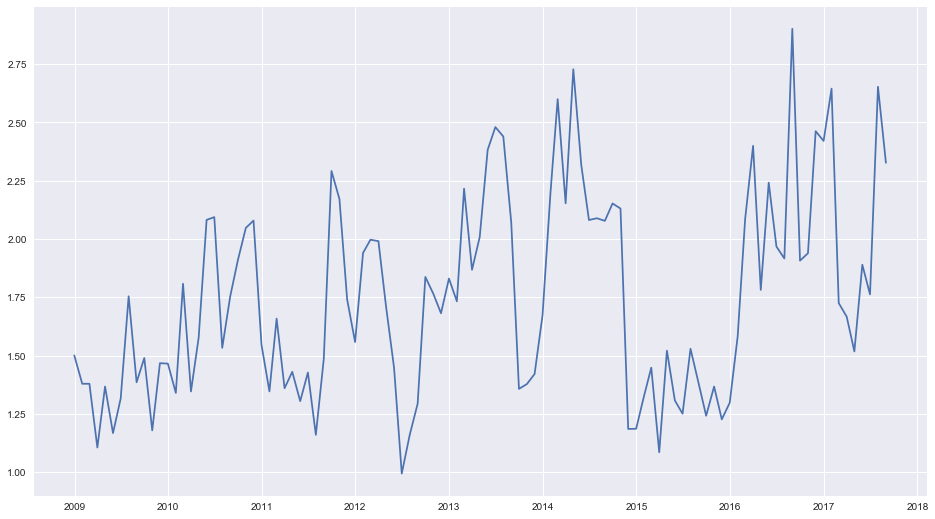

In [554]:
plt.figure(figsize=(16, 9))
plt.plot(dis_series)